In [1]:
import os
os.chdir('..')
from notebooks import config
import numpy as np
import torch
import time
import random
import glob
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from utils.metric import oa_binary, miou_binary
from utils.imgShow import imsShow
from dataloader.preprocess import read_normalize
from model.seg_model.model_scales_in import unet_scales
from model.seg_model.model_scales_gate import unet_scales_gate
# from model.seg_model.deeplabv3_plus import deeplabv3plus, deeplabv3plus_imp
from dataloader.parallel_loader import threads_scene_dset
from dataloader.loader import patch_tensor_dset


In [2]:
# ----------- Device --------------- #
device = torch.device('cuda:1')

# ---------- setting ------- #
torch.manual_seed(999)   # make the trianing replicable


In [3]:
# ---------- Data paths ----------- #
paths_as = sorted(glob.glob(config.dir_as + '/*'))
paths_des = sorted(glob.glob(config.dir_des+'/*'))
paths_truth = sorted(glob.glob(config.dir_truth+'/*'))
paths_patch_val = sorted(glob.glob(config.dir_patch_val+'/*'))
print(paths_as[0])


/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/s1_ascend/s1_as_scene_01.tif


In [4]:
'''--------- data loading --------'''
### ------ 1. training data loading: from scenes path ----- ### 
scene_list, truth_list = read_normalize(paths_as=paths_as, \
                            paths_des=paths_des, paths_truth=paths_truth)
### !!!!extract ascending or descending image.
# scene_list = [s[2:4] for s in scene_list]       
tra_dset = threads_scene_dset(scene_list[0:20], \
                            truth_list[0:20], transforms=config.transforms_tra, num_thread=30)

### ----- 2. val data loading: from prepared validation patches ------ ###
patch_list_val = [torch.load(path) for path in paths_patch_val]
# # !!!extract ascending or descending image
# for i in range(len(patch_list_val)):
#    for j in range(len(patch_list_val[0][0])):
#       patch_list_val[i][0][j] = patch_list_val[i][0][j][2:4]

val_dset = patch_tensor_dset(patch_pair_list = patch_list_val)

### ------- print ------- ###
print('size of training data:', tra_dset.__len__())
print('size of val data:', val_dset.__len__())


size of training data: 600
size of val data: 250


In [5]:
tra_loader = torch.utils.data.DataLoader(tra_dset, \
                                batch_size=config.batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dset, \
                                batch_size=16)


In [6]:
## ------------ Model ------------ ##
## -------- 3. gated multiple scales -------
model = unet_scales_gate(num_bands=4, num_classes=2, \
                    scale_high=2048, scale_mid=512, scale_low=256).to(device)


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,\
                                        mode='min', factor=0.5, patience=10)


In [8]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred,_,_ = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred,_,_ = model(x)
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------ train loops ------'''
def train_loops(model, loss_fn, optimizer, tra_loader, val_loader, epoches, lr_scheduler):
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    tra_loss_loops, tra_miou_loops = [], []
    val_loss_loops, val_miou_loops = [], []
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0

        '''----- 1. train the model -----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = [batch.to(device) for batch in x_batch], y_batch.to(device)
            # x_batch = x_batch[2]      # !!!note: x_batch[2] for single-scale model
            y_batch = config.label_smooth(y_batch, 0.1)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                        optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        lr_scheduler.step(tra_loss)         # dynamic adjust learning rate

        '''----- 2. validate the model -----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = [batch.to(device) for batch in x_batch], y_batch.to(device)    
            # x_batch = x_batch[2]          #!!!note: x_batch[2] for single-scale model
            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, 
                                        x=x_batch, y=y_batch)

            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()

        '''------ 3. print accuracy ------'''
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss), tra_miou_loops.append(tra_miou)
        val_loss_loops.append(val_loss), val_miou_loops.append(val_miou)

        format = 'Ep{}: tra-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f}, val-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f},time:{:.1f}s'
        print(format.format(epoch+1, tra_loss, tra_oa, tra_miou, val_loss, val_oa, val_miou, time.time()-start))

        '''------- 4. visualize the result -------'''
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_dset))
            patches, truth = val_dset[sam_index]
            patches = [torch.unsqueeze(patch, 0).to(device) for patch in patches]
            truth = truth.to(device)
            # pred = model(patches[2])           # !!! note: x[2] for single-scale model
            pred, gate_mid, gate_high = model(patches)
            patches = [patch[0].to('cpu').detach().numpy().transpose(1,2,0) for patch in patches]
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            # gate_mid = gate_mid.to('cpu').detach().numpy()
            # gate_high = gate_high.to('cpu').detach().numpy()
            pred = np.where(pred>0.5, 1, 0)
            patches_list = patches + [truth, pred]
            # patches_list = patches + [gate_high[0][0], gate_mid[0][0]] + [truth, pred]
            # ---- plot result
            # print(f'gate_mid:{gate_mid[0,0,0,0]:.2f}, gate_high:{gate_high[0,0,0,0]:.2f}')
            plt.figure(figsize=(14,4))
            # patches_name = ['input_high','input_mid','input_low','gate_high','gate_mid','truth','pred']
            patches_name = ['input_high','input_mid','input_low','truth','pred']
            clip_list = [2,2,2,0,0]
            col_bands_list = [(2,1,0), (2,1,0), (2,1,0), (0,0,0), (0,0,0)]
            imsShow(img_list=patches_list, img_name_list=patches_name, \
                                clip_list=clip_list, color_bands_list=col_bands_list)
            plt.show()

    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'val_loss': val_loss_loops, 'val_miou': val_miou_loops}
    return metrics
    

Ep1: tra-> Loss:0.511,Oa:0.814,Miou:0.702, val-> Loss:0.239,Oa:0.953,Miou:0.909,time:9.5s
Ep2: tra-> Loss:0.474,Oa:0.873,Miou:0.756, val-> Loss:0.314,Oa:0.896,Miou:0.709,time:9.1s
Ep3: tra-> Loss:0.448,Oa:0.887,Miou:0.792, val-> Loss:0.263,Oa:0.928,Miou:0.806,time:9.0s
Ep4: tra-> Loss:0.432,Oa:0.899,Miou:0.811, val-> Loss:0.205,Oa:0.955,Miou:0.913,time:9.0s
Ep5: tra-> Loss:0.432,Oa:0.913,Miou:0.828, val-> Loss:0.229,Oa:0.923,Miou:0.869,time:9.0s
Ep6: tra-> Loss:0.427,Oa:0.909,Miou:0.832, val-> Loss:0.194,Oa:0.931,Miou:0.883,time:9.0s
Ep7: tra-> Loss:0.418,Oa:0.915,Miou:0.842, val-> Loss:0.221,Oa:0.930,Miou:0.882,time:9.0s
Ep8: tra-> Loss:0.421,Oa:0.918,Miou:0.840, val-> Loss:0.196,Oa:0.966,Miou:0.923,time:9.0s
Ep9: tra-> Loss:0.407,Oa:0.931,Miou:0.861, val-> Loss:0.178,Oa:0.952,Miou:0.918,time:9.0s
Ep10: tra-> Loss:0.404,Oa:0.930,Miou:0.864, val-> Loss:0.169,Oa:0.953,Miou:0.918,time:9.0s


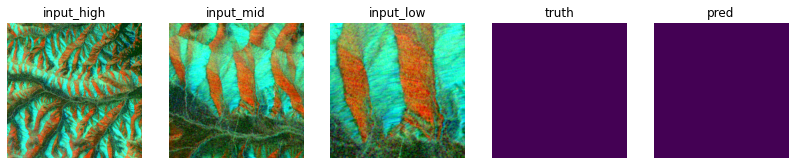

Ep11: tra-> Loss:0.390,Oa:0.943,Miou:0.888, val-> Loss:0.170,Oa:0.963,Miou:0.933,time:9.0s
Ep12: tra-> Loss:0.391,Oa:0.941,Miou:0.880, val-> Loss:0.171,Oa:0.968,Miou:0.944,time:9.1s
Ep13: tra-> Loss:0.422,Oa:0.922,Miou:0.844, val-> Loss:0.174,Oa:0.956,Miou:0.922,time:9.0s
Ep14: tra-> Loss:0.414,Oa:0.921,Miou:0.853, val-> Loss:0.207,Oa:0.961,Miou:0.894,time:9.0s
Ep15: tra-> Loss:0.391,Oa:0.942,Miou:0.884, val-> Loss:0.159,Oa:0.960,Miou:0.932,time:9.1s
Ep16: tra-> Loss:0.406,Oa:0.935,Miou:0.867, val-> Loss:0.205,Oa:0.952,Miou:0.917,time:9.1s
Ep17: tra-> Loss:0.411,Oa:0.926,Miou:0.854, val-> Loss:0.164,Oa:0.959,Miou:0.925,time:9.0s
Ep18: tra-> Loss:0.382,Oa:0.950,Miou:0.904, val-> Loss:0.162,Oa:0.961,Miou:0.932,time:9.1s
Ep19: tra-> Loss:0.388,Oa:0.944,Miou:0.895, val-> Loss:0.176,Oa:0.975,Miou:0.933,time:9.0s
Ep20: tra-> Loss:0.382,Oa:0.954,Miou:0.901, val-> Loss:0.181,Oa:0.946,Miou:0.908,time:9.0s


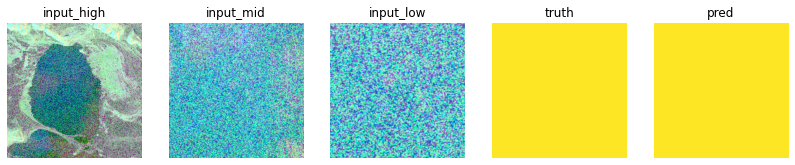

Ep21: tra-> Loss:0.383,Oa:0.949,Miou:0.903, val-> Loss:0.178,Oa:0.966,Miou:0.920,time:9.0s
Ep22: tra-> Loss:0.402,Oa:0.941,Miou:0.881, val-> Loss:0.187,Oa:0.954,Miou:0.920,time:9.1s
Ep23: tra-> Loss:0.374,Oa:0.957,Miou:0.913, val-> Loss:0.179,Oa:0.971,Miou:0.929,time:9.1s
Ep24: tra-> Loss:0.363,Oa:0.970,Miou:0.935, val-> Loss:0.169,Oa:0.973,Miou:0.943,time:9.1s
Ep25: tra-> Loss:0.368,Oa:0.961,Miou:0.922, val-> Loss:0.154,Oa:0.969,Miou:0.946,time:9.1s
Ep26: tra-> Loss:0.361,Oa:0.967,Miou:0.934, val-> Loss:0.160,Oa:0.960,Miou:0.933,time:9.1s
Ep27: tra-> Loss:0.381,Oa:0.950,Miou:0.903, val-> Loss:0.163,Oa:0.975,Miou:0.941,time:9.1s
Ep28: tra-> Loss:0.362,Oa:0.963,Miou:0.933, val-> Loss:0.170,Oa:0.966,Miou:0.935,time:9.1s


In [9]:
metrics = train_loops(model=model,  
                    loss_fn=config.loss_bce,  
                    optimizer=optimizer,  
                    tra_loader=tra_loader,  
                    val_loader=val_loader,  
                    epoches=config.epoch,   
                    lr_scheduler=lr_scheduler)


## Model and metrics saving


In [ ]:
# model_name = 'model_scales_gate'
# # model save/load
# model_weights = config.root + '/model/pretrained/' + model_name + '_weights.pth'
# torch.save(model.state_dict(), model_weights)
# model.load_state_dict(torch.load(model_weights))



<All keys matched successfully>

In [ ]:
# ## metrics saving
# metrics_path = config.root + '/model/pretrained/' + model_name + '_metrics.csv'
# metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv(metrics_path, index=False, sep=',')
# # metrics_df = pd.read_csv(metrics_path)

